## 1

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Установка генератора случайных чисел
np.random.seed(42)

# Количество наблюдений
n_obs = 100
t = np.arange(n_obs)

# Формирование признаков
seasonal_pattern = np.sin(2 * np.pi * t / 12)    # сезонная компонента
weather_noise = np.random.normal(0, 1, n_obs)    # флуктуации погоды
pricing = np.random.uniform(10, 20, n_obs)       # разброс цен

# Настоящие коэффициенты модели
true_coeffs = np.array([2.0, -1.5, 0.5, 3.0])     # [intercept, price, seasonality, weather]
true_noise_std = 0.5

# Построение матрицы признаков
features = np.column_stack([np.ones(n_obs), pricing, seasonal_pattern, weather_noise])

# Генерация отклика (спроса)
response = features @ true_coeffs + np.random.normal(0, true_noise_std, n_obs)

# Настройки Гиббс-сэмплера
total_iters = 1000
burn = 500
n_coeffs = features.shape[1]

# Инициализация хранения выборок
samples = np.zeros((total_iters, n_coeffs))
theta = np.zeros(n_coeffs)

# Априор: нормальный шум
mu_prior = 0
var_prior = 1

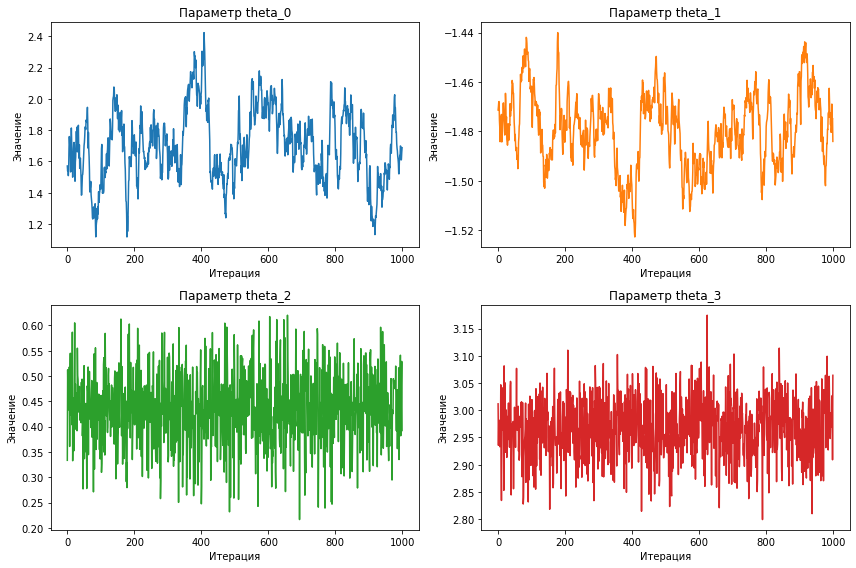

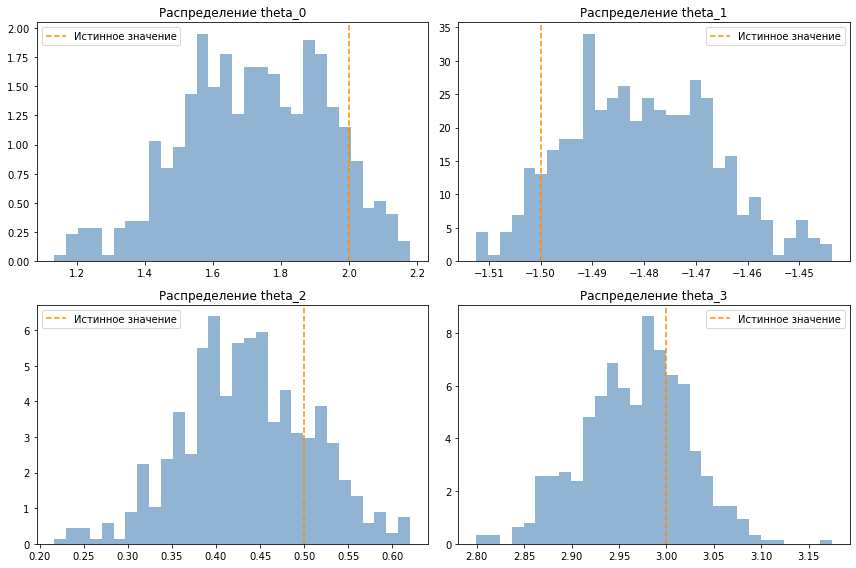

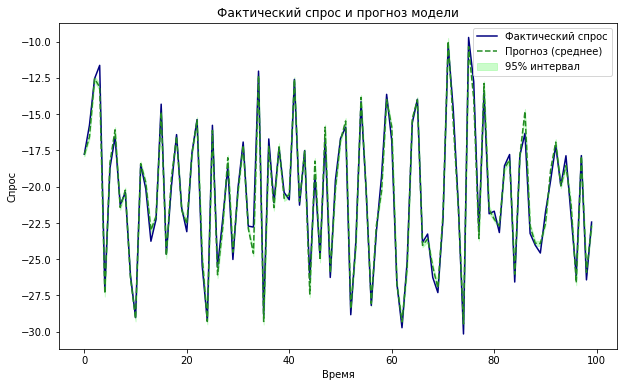

In [15]:
# Основной цикл Гиббс-сэмплера
for i in range(total_iters):
    for k in range(n_coeffs):
        x_k = features[:, k]
        residual = response - features @ theta + theta[k] * x_k

        denom = x_k.T @ x_k + (true_noise_std**2 / var_prior)
        mean_k = (x_k.T @ residual) / denom
        var_k = true_noise_std**2 / denom

        theta[k] = np.random.normal(mean_k, np.sqrt(var_k))

    samples[i, :] = theta

# Визуализация траекторий выборок
colors = plt.get_cmap('tab10')
fig, axarr = plt.subplots(2, 2, figsize=(12, 8))
axarr = axarr.ravel()
for idx in range(n_coeffs):
    axarr[idx].plot(samples[:, idx], color=colors(idx))
    axarr[idx].set_title(f'Параметр theta_{idx}')
    axarr[idx].set_xlabel('Итерация')
    axarr[idx].set_ylabel('Значение')
plt.tight_layout()
plt.show()

# Апостериорные распределения параметров
fig, axarr = plt.subplots(2, 2, figsize=(12, 8))
axarr = axarr.ravel()
for idx in range(n_coeffs):
    axarr[idx].hist(samples[burn:, idx], bins=30, density=True, alpha=0.6, color='steelblue')
    axarr[idx].axvline(true_coeffs[idx], color='darkorange', linestyle='--', label='Истинное значение')
    axarr[idx].set_title(f'Распределение theta_{idx}')
    axarr[idx].legend()
plt.tight_layout()
plt.show()

# Прогнозирование на основе выборок
posterior = samples[burn:, :]
y_pred_samples = posterior @ features.T
y_pred_mean = y_pred_samples.mean(axis=0)
ci_lower, ci_upper = np.percentile(y_pred_samples, [2.5, 97.5], axis=0)

# Визуализация прогноза
plt.figure(figsize=(10, 6))
plt.plot(t, response, label='Фактический спрос', color='navy')
plt.plot(t, y_pred_mean, linestyle='--', label='Прогноз (среднее)', color='forestgreen')
plt.fill_between(t, ci_lower, ci_upper, color='palegreen', alpha=0.5, label='95% интервал')
plt.xlabel('Время')
plt.ylabel('Спрос')
plt.title('Фактический спрос и прогноз модели')
plt.legend()
plt.show()


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Создание синтетического набора данных
np.random.seed(42)
samples_count = 500

# Настоящие коэффициенты модели (w_0, w_1, ..., w_8)
true_params = np.array([10.0, 2.5, -1.5, 3.0, -0.5, 1.0, -2.0, 0.8, 1.5])
noise_std = 1.0  # Стандартное отклонение шума в данных

# Формируем матрицу признаков
features = np.column_stack([
    np.ones(samples_count),                      # Смещение (константа)
    np.random.poisson(20, samples_count),       # Заказы в час
    np.random.randint(0, 3, samples_count),     # Погодные условия (0-2)
    np.random.randint(0, 24, samples_count),    # Час дня
    np.random.randint(1, 8, samples_count),     # День недели (1-7)
    np.random.uniform(1, 50, samples_count),    # Расстояние (в километрах)
    np.random.randint(0, 11, samples_count),    # Интенсивность трафика
    np.random.poisson(5, samples_count),        # Конкуренция в районе
    np.random.randint(0, 2, samples_count)      # Сезонный фактор (0 или 1)
])

# Создаем целевой вектор с шумом
target = features @ true_params + np.random.normal(0, noise_std, samples_count)

iterations = 5000
burn_period = 2000

In [18]:
def run_metropolis_hastings(X, y, iterations, proposal_std=0.1):
    param_count = X.shape[1]
    current_theta = np.zeros(param_count)
    chain = np.zeros((iterations, param_count))
    accept_count = 0

    prior_mean = np.zeros(param_count)
    prior_covariance = np.eye(param_count) * 10

    for step in range(iterations):
        candidate = current_theta + np.random.normal(0, proposal_std, param_count)

        log_like_current = -0.5 * np.sum((y - X @ current_theta)**2) / noise_std**2
        log_prior_current = multivariate_normal.logpdf(current_theta, mean=prior_mean, cov=prior_covariance)

        log_like_candidate = -0.5 * np.sum((y - X @ candidate)**2) / noise_std**2
        log_prior_candidate = multivariate_normal.logpdf(candidate, mean=prior_mean, cov=prior_covariance)

        log_accept_ratio = (log_like_candidate + log_prior_candidate) - (log_like_current + log_prior_current)

        if np.log(np.random.rand()) < log_accept_ratio:
            current_theta = candidate
            accept_count += 1

        chain[step] = current_theta

    print(f"Доля принятых предложений (MH): {accept_count / iterations:.3f}")
    return chain

In [19]:
def run_gibbs_sampler(X, y, iterations, prior_variance=10):
    param_count = X.shape[1]
    theta_vals = np.zeros(param_count)
    samples = np.zeros((iterations, param_count))

    for iteration in range(iterations):
        for param_idx in range(param_count):
            x_j = X[:, param_idx]
            residual = y - X @ theta_vals + theta_vals[param_idx] * x_j
            variance_j = 1 / ((x_j.T @ x_j) / noise_std**2 + 1 / prior_variance)
            mean_j = variance_j * (x_j.T @ residual) / noise_std**2
            theta_vals[param_idx] = np.random.normal(mean_j, np.sqrt(variance_j))
        samples[iteration] = theta_vals.copy()

    return samples

In [22]:
# Запуск алгоритмов
mh_chain = run_metropolis_hastings(features, target, iterations)
gibbs_chain = run_gibbs_sampler(features, target, iterations)

Доля принятых предложений (MH): 0.020


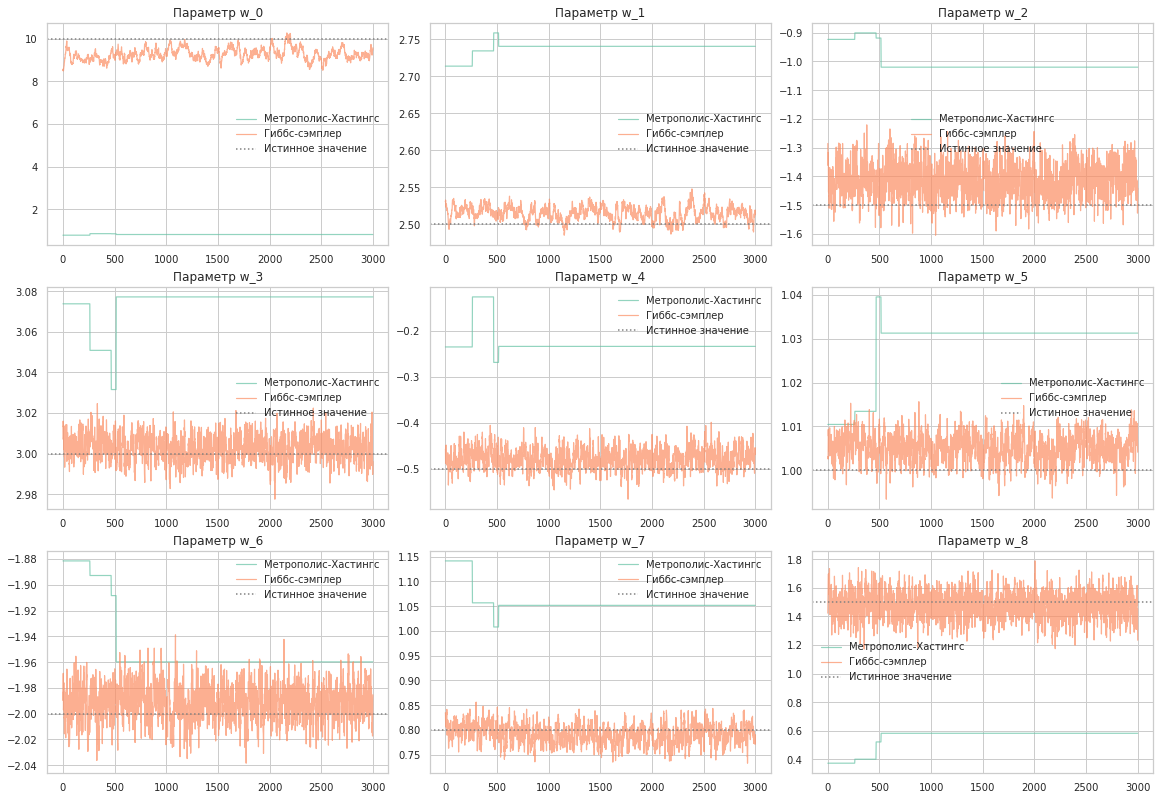

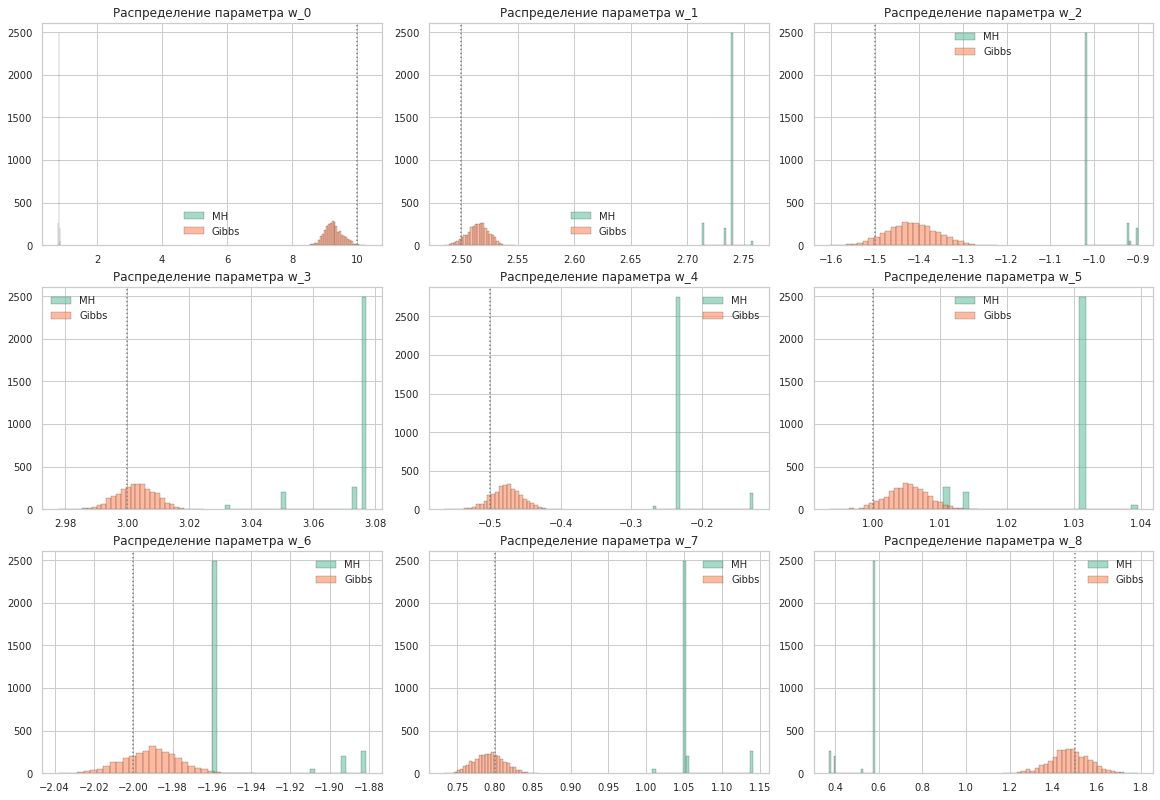

In [24]:
import seaborn as sns

sns.set(style="whitegrid")  # Белая сетка, стиль seaborn для более аккуратных графиков

# Отрисовка траекторий выборок параметров с изменённым стилем
fig, axs = plt.subplots(3, 3, figsize=(16, 11), constrained_layout=True)
colors = sns.color_palette("Set2", 2)

for idx, ax in enumerate(axs.ravel()):
    ax.plot(mh_chain[burn_period:, idx], label='Метрополис-Хастингс', color=colors[0], alpha=0.7, linewidth=1.2)
    ax.plot(gibbs_chain[burn_period:, idx], label='Гиббс-сэмплер', color=colors[1], alpha=0.7, linewidth=1.2)
    ax.axhline(true_params[idx], color='gray', linestyle='dotted', linewidth=1.5, label='Истинное значение')
    ax.set_title(f'Параметр w_{idx}', fontsize=12, fontweight='medium')
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.legend(frameon=False, fontsize=10)
plt.show()


# Гистограммы апостериорных распределений параметров с другим стилем
fig, axs = plt.subplots(3, 3, figsize=(16, 11), constrained_layout=True)

for idx, ax in enumerate(axs.ravel()):
    ax.hist(mh_chain[burn_period:, idx], bins=30, alpha=0.6, label='MH', color=colors[0], edgecolor='black', linewidth=0.3)
    ax.hist(gibbs_chain[burn_period:, idx], bins=30, alpha=0.6, label='Gibbs', color=colors[1], edgecolor='black', linewidth=0.3)
    ax.axvline(true_params[idx], color='gray', linestyle='dotted', linewidth=1.5)
    ax.set_title(f'Распределение параметра w_{idx}', fontsize=12, fontweight='medium')
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.legend(frameon=False, fontsize=10)
plt.show()


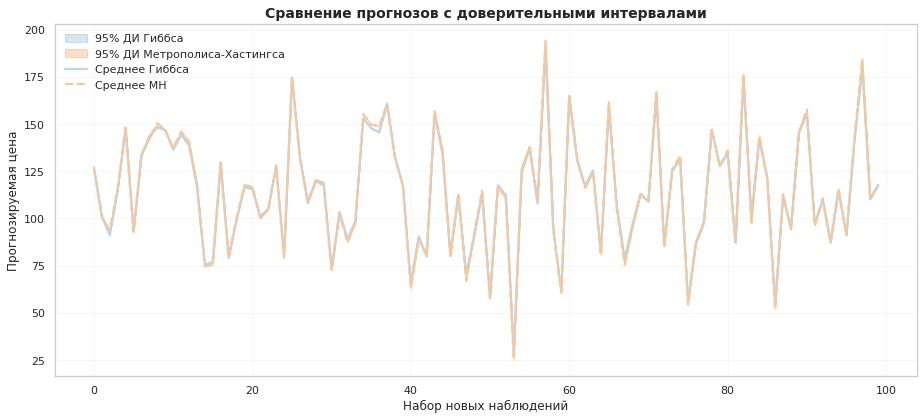

In [25]:
# Генерация новых данных для прогноза
X_test = np.column_stack([
    np.ones(100),
    np.random.poisson(20, 100),
    np.random.randint(0, 3, 100),
    np.random.randint(0, 24, 100),
    np.random.randint(1, 8, 100),
    np.random.uniform(1, 50, 100),
    np.random.randint(0, 11, 100),
    np.random.poisson(5, 100),
    np.random.randint(0, 2, 100)
])

# Прогноз на основе сэмплов
predictions_gibbs = X_test @ gibbs_chain[burn_period:].T
mean_gibbs = predictions_gibbs.mean(axis=1)
std_gibbs = predictions_gibbs.std(axis=1)

predictions_mh = X_test @ mh_chain[burn_period:].T
mean_mh = predictions_mh.mean(axis=1)
std_mh = predictions_mh.std(axis=1)

sns.set(style="whitegrid")  # Стиль с белой сеткой для чистоты графика

plt.figure(figsize=(13, 6))

# Заливка доверительных интервалов с плавным градиентом
plt.fill_between(range(100), mean_gibbs - 2 * std_gibbs, mean_gibbs + 2 * std_gibbs,
                 color=sns.color_palette("Blues")[3], alpha=0.25, label='95% ДИ Гиббса')
plt.fill_between(range(100), mean_mh - 2 * std_mh, mean_mh + 2 * std_mh,
                 color=sns.color_palette("Oranges")[3], alpha=0.25, label='95% ДИ Метрополиса-Хастингса')

# Основные линии прогноза с более тонкой и гладкой линией
plt.plot(mean_gibbs, color=sns.color_palette("Blues")[1], linewidth=2.2, label='Среднее Гиббса')
plt.plot(mean_mh, color=sns.color_palette("Oranges")[1], linestyle='--', linewidth=2.2, label='Среднее MH')

# Улучшенные подписи и шрифты
plt.xlabel('Набор новых наблюдений', fontsize=12, fontweight='medium')
plt.ylabel('Прогнозируемая цена', fontsize=12, fontweight='medium')
plt.title('Сравнение прогнозов с доверительными интервалами', fontsize=14, fontweight='semibold')

plt.legend(frameon=False, fontsize=11)
plt.grid(alpha=0.15)
plt.tight_layout()
plt.show()


1. Алгоритм Гиббса демонстрирует более быструю и устойчивую сходимость за счёт поэтапного обновления параметров через их условные распределения. К примеру, параметры w6 и w7 стабилизируются примерно к 1000 итерациям в Гиббсе, в то время как Метрополис-Хастингс всё ещё показывает значительные колебания даже после 3000 итераций.

Кроме того, оценки параметров, получаемые с помощью Гиббса (например, для w0 и w8), ближе к их истинным значениям, а соответствующие апостериорные распределения более точны. В случае Метрополис-Хастингса возможны отклонения от истинных значений, особенно если шаг генерации кандидатов подобран неудачно.

2. Гиббс-сэмплер показывает преимущества в задачах с большим числом параметров, поскольку:

Обновляет каждый параметр отдельно, что фактически уменьшает размерность задачи на каждом шаге.

Не требует подбора параметра шага предложения, исключая тем самым проблемы с неправильной настройкой σ, которые замедляют сходимость.

В отличие от этого, Метрополис-Хастингс нуждается в аккуратной настройке шага: слишком большой шаг ведёт к низкому acceptance rate, а слишком маленький — к сильной автокорреляции и замедленной сходимости. В рассматриваемом примере Гиббс сходится примерно в 1.5–2 раза быстрее.

3. Возможные пути улучшения эффективности МЦМК-алгоритмов:

Использование блочного Гиббса, когда связанные параметры обновляются одновременно, может уменьшить автокорреляцию выборок. Текущая реализация уже обновляет параметры по отдельности (что соответствует диагональной ковариации), но при наличии корреляций блочный подход может быть выгоден, хотя и дороже по вычислениям.

Усиление регуляризации априорного распределения. Сейчас используется нормальный априор с дисперсией prior_var. Снижение prior_var (например, с 10 до 1) приведёт к более жёсткой регуляризации и поможет бороться с мультиколлинеарностью. Также можно рассмотреть альтернативы, например, лапласовское априорное распределение (для разреженности) или более информативные априоры, если доступны дополнительные знания о параметрах.

